In [1]:
import numpy as np
import tensorflow as tf

# RHIRL
# import sys
# sys.path.append("../../irl/rhirl/")
# from rhirl import *
# from rhirl_plotting import *

# Simple RL
from simple_rl.tasks import NavigationMDP
from simple_rl.agents import QLearningAgent
from simple_rl.planning import ValueIteration
from simple_rl.tasks.grid_world.GridWorldStateClass import GridWorldState

# Torch
import torch
import torch.optim as optim
from torch import FloatTensor
from torch.autograd import Variable

# https://github.com/pandas-profiling/pandas-profiling/issues/68
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

# MLIRL

In [48]:
def MLIRL(state_trajectories, action_trajectories,
          states, state_features, 
          actions, trans_dict, optimizer_fn,
          n_iter=1, n_vi_iter=1,
          gamma=0.99, boltzmann_beta=1., 
          dtype=torch.float, print_interval=1):
    
    nS = len(states)
    nA = len(actions)
    state_features = torch.from_numpy(state_features).type(dtype)
    feature_dim = state_features.shape[1]
    state_to_idx = {s:idx for idx,s in enumerate(states)}
    action_to_idx = {a:idx for idx,a in enumerate(actions)}
    softmax = torch.nn.Softmax(dim=0)
    # Reward parameters
    w = Variable(torch.Tensor(feature_dim, 1).normal_(0, 0.01).type(dtype), requires_grad=True) # weight init normal random
    # w = Variable(torch.Tensor(feature_dim, 1).type(dtype), requires_grad=True) # weight init zero
    # torch.ones(feature_dim, 1, dtype=dtype, requires_grad=True)
    optimizer = optimizer_fn([w])
    
    for _iter in range(n_iter):
        # Stochastic Policy
        Pi = torch.ones(nS, nA, dtype=dtype) / nA
        # Reward^~
        R = torch.mm(state_features, w)
        # Value
        V = R[:,0].clone()
        # V = gtorch.zeros(nS, dtype=dtype)
        # Q value
        Q = R.repeat(1,nA).clone()
        # Q = torch.zeros(nS, nA, dtype=dtype)

        for _v_iter in range(n_vi_iter):
            for s_idx, s in enumerate(states):
                
                # Check if state is terminal (stop leaking values back to non-goal state space)
                if s.is_terminal():
                    continue
                    
                phi_s = state_features[s_idx] #torch.from_numpy(phi(s)).type(dtype)
                for a_idx, a in enumerate(actions):

                    Q[s_idx, a_idx] = R[s_idx]
                    for s_prime in trans_dict[s][a]:
                        Q[s_idx, a_idx] += gamma * trans_dict[s][a][s_prime] * V[state_to_idx[s_prime]].clone()
                    Pi[s_idx, :] = softmax(boltzmann_beta * Q[s_idx,:].clone())
                    V[s_idx] = Pi[s_idx, :].clone().dot(Q[s_idx,:].clone())
                    
        optimizer.zero_grad()
        loss = 0
        for traj_idx, state_trajectory in enumerate(state_trajectories):
            for point_idx, state in enumerate(state_trajectory[:-1]):
                s_idx = state_to_idx[state]
                a_idx = action_to_idx[action_trajectories[traj_idx][point_idx]]
                loss -= torch.log(Pi[s_idx,a_idx])
        loss.backward()
        if _iter % print_interval == 0 or _iter == n_iter-1:
            print("Iter: {:04d}, loss: {:012.6f}, w: [{}], dw: [{}]".format(
                _iter, loss, ' '.join("{:+10.8f}".format(v) for v in w[:,0]), ' '.join("{:+10.9f}".format(v) for v in -w.grad[:,0])))
        optimizer.step()
    return w, R, Pi, V, Q, loss


# Experiments

In [44]:
def get_action(state, n_state):
    dx = n_state[0] - state[0]
    dy = n_state[1] - state[1]
    if dx > 0 and dy == 0:
        return "right"
    elif dx > 0 and dy > 0:
        return "up_right"
    elif dx == 0 and dy > 0:
        return "up"
    elif dx < 0 and dy > 0:
        return "up_left"
    elif dx < 0 and dy == 0:
        return "left"
    elif dx < 0 and dy < 0:
        return "down_left"
    elif dx == 0 and dy < 0:
        return "down"
    elif dx > 0 and dy < 0:
        return "down_right" 
    else: #dx == 0 and dy == 0:
        return "None"

def get_actions_from_state_traj(state_traj):
    return [get_action(state_traj[i], state_traj[i+1]) for i in range(len(state_traj)-1)]

def map_v_to_grid(states, V, nvmdp):
    V_grid = np.zeros((nvmdp.height, nvmdp.width))
    for i in range(len(states)):
        r, c = nvmdp._xy_to_rowcol(states[i].x, states[i].y)
        V_grid[r,c] = V[i]
    return V_grid

def MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=True, figsize=(10,10), print_interval=1):
    
    # Navigation MDP with no goals
    nvmdp = NavigationMDP(width=irl_problem["width"], height=irl_problem["height"],
                          living_cell_types=irl_problem["cell_types"],
                          living_cell_rewards=[0]*len(irl_problem["cell_types"]),
                          living_cell_distribution="manual",
                          living_cell_locs= irl_problem["cell_locs"],
                          goal_cell_locs=irl_problem["goal_locs"],
                          goal_cell_types=irl_problem["goal_types"],
                          goal_cell_rewards=[0]*len(irl_problem["goal_types"]))
    # Visualize Grid
    if disp_grid:
        nvmdp.visualize_grid(nvmdp.state_space, trajectories=irl_problem["traj_states"], 
                             state_space_cmap=plt.cm.viridis, end_marker="*k", goal_marker_sz=10, title=irl_problem["title"])
    
    # MLIRL Inputs
    phi = lambda s: nvmdp.feature_at_state(s, "indicator", incl_cell_distances=False, incl_goal_indicator=True, incl_goal_distances=False, normalize_distance=False)
    phi_loc = lambda x,y: nvmdp.feature_at_loc(x, y, "indicator", incl_cell_distances=False, incl_goal_indicator=True, incl_goal_distances=False, normalize_distance=False)
    states = nvmdp.get_states()
    actions = nvmdp.get_actions()
    state_features = np.asarray([phi(s) for s in states])
    cell_features = np.asarray([[phi_loc(*nvmdp._rowcol_to_xy(row,col)) for col in range(nvmdp.width)] for row in range(nvmdp.height)])
    T = nvmdp.get_trans_dict()
    # MLIRL
    print("Training...\n \t\t\t\t \t {}  \t {} ".format(' '.join("{:11}".format(v) for v in nvmdp.cell_types), ' '.join("{:11}".format(v) for v in nvmdp.cell_types)))
    w, _, Pi, V, Q, loss = MLIRL(irl_problem["traj_states"], irl_problem["traj_actions"], states, state_features, actions, T, **mlirl_params, print_interval=print_interval)
    print("Done.")
    # Recovered Reward
    R = cell_features.dot(w.data)[:,:,0]
    # Map values to grid
    V_grid = map_v_to_grid(states, V, nvmdp)
    
    # Display results
    if disp_results:
        display_irl_results(nvmdp, irl_problem["traj_states"], R, V_grid, title, figsize)
    return dict(w=w, R=R, Pi=Pi, V=V, Q=Q, nvmdp=nvmdp, phi=phi, phi_loc=phi_loc, V_grid=V_grid)

def display_irl_results(nvmdp, tau_s, recovered_R, V=None, title="", rewards_cmap=None, figsize=(24,14)):
    
    plt.figure(figsize=figsize)
    nvmdp.visualize_grid(nvmdp.state_space, new_fig=False, subplot_str="121", trajectories=tau_s, 
                         state_space_cmap=True, show_colorbar=False, end_marker="*k", title=title)
    nvmdp.visualize_grid(recovered_R, new_fig=False, subplot_str="122", cmap=rewards_cmap, state_space_cmap=False,
                         show_colorbar=True, text_values=recovered_R, text_size=15, title="MLIRL Recovered R")
    if V is not None:
        plt.figure(figsize=(figsize[0],int(1*figsize[1]/2)))
        nvmdp.visualize_grid(V, new_fig=False, state_space_cmap=False, show_colorbar=True,
                             text_values=V, text_size=15, title="MLIRL V")

### Michael Littman MDP (RL class)

In [5]:
mlirl_params = dict(
    n_iter = 20,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.95,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 10,
    height = 5,
    cell_types = ['white', 'blue', "orange", "red", "green"],
    cell_locs = [np.inf, [(2,4), (4,2), (7,3), (9,5)], [(6,i) for i in range(1,6)], [(8,i) for i in range(1,4)], [(10,1)]],
    tau_s = [[(1,5),(2,5)] + [(3,i) for i in range(5,0,-1)] + [(i,1) for i in range(4,11)]]
)
irl_problem = dict(
    mdp_params, 
    title="Michael Littman MDP (RL class)",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), results["V_grid"].round(4), irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

KeyError: 'goal_locs'

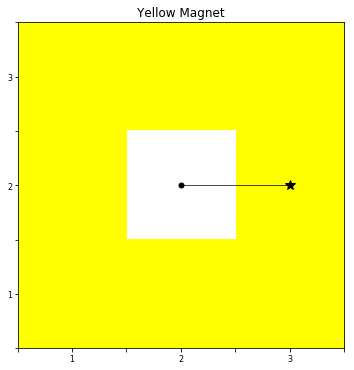

Training...
 				 	 white       yellow       	 white       yellow      
Iter: 0000, loss: 00001.386324, w: [+0.00804729 +0.01160787], dw: [-0.000245195 -0.002393752]
Iter: 0001, loss: 00001.386324, w: [+0.00796437 +0.01146786], dw: [-0.000246021 -0.002394855]
Iter: 0002, loss: 00001.386323, w: [+0.00780763 +0.01120322], dw: [-0.000247040 -0.002393752]
Iter: 0003, loss: 00001.386322, w: [+0.00758602 +0.01082907], dw: [-0.000248658 -0.002394199]
Iter: 0004, loss: 00001.386321, w: [+0.00730823 +0.01036010], dw: [-0.000250263 -0.002391517]
Iter: 0005, loss: 00001.386319, w: [+0.00698262 +0.00981052], dw: [-0.000252041 -0.002388149]
Iter: 0006, loss: 00001.386318, w: [+0.00661724 +0.00919391], dw: [-0.000254297 -0.002385467]
Iter: 0007, loss: 00001.386316, w: [+0.00621967 +0.00852316], dw: [-0.000257407 -0.002386510]
Iter: 0008, loss: 00001.386314, w: [+0.00579710 +0.00781039], dw: [-0.000259990 -0.002383232]
Iter: 0009, loss: 00001.386312, w: [+0.00535620 +0.00706697], dw: [-0.000262868 -0

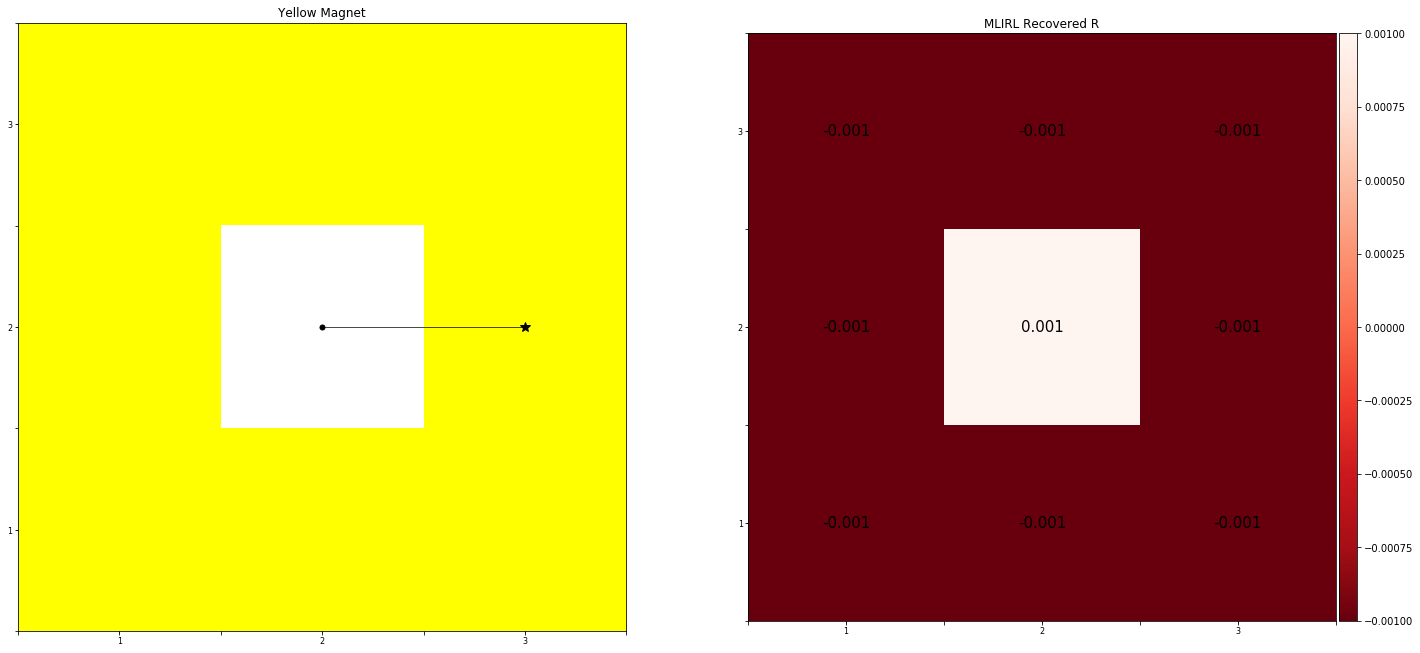

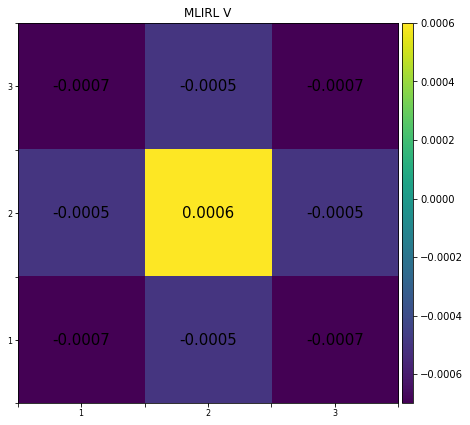

In [5]:
mlirl_params = dict(
    n_iter = 20,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.95,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 3,
    height = 3,
    cell_types = ['white', 'yellow'],
    cell_locs = [[(2,2)], np.inf],
    tau_s = [[(2,2),(3,2)]]
)
irl_problem = dict(
    mdp_params, 
    title="Yellow Magnet",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), results["V_grid"].round(4), irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

### Yellow Magnet

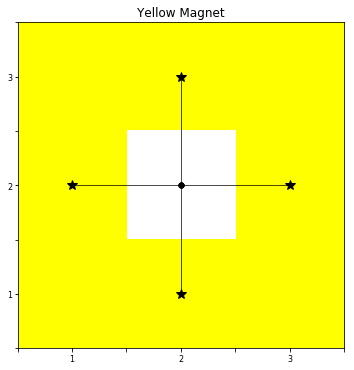

Training...
 				 	 white       yellow       	 white       yellow      
Iter: 0000, loss: 00005.545177, w: [-0.00893315 -0.00820933], dw: [+0.000000021 +0.000000175]
Iter: 0001, loss: 00005.545177, w: [-0.00884382 -0.00812723], dw: [+0.000000021 +0.000000174]
Iter: 0002, loss: 00005.545177, w: [-0.00867498 -0.00797207], dw: [-0.000000715 -0.000003821]
Iter: 0003, loss: 00005.545177, w: [-0.00843628 -0.00775275], dw: [-0.000000715 -0.000003825]
Iter: 0004, loss: 00005.545177, w: [-0.00813710 -0.00747786], dw: [+0.000000755 +0.000004155]
Iter: 0005, loss: 00005.545177, w: [-0.00778646 -0.00715565], dw: [+0.000000019 +0.000000156]
Iter: 0006, loss: 00005.545177, w: [-0.00739302 -0.00679410], dw: [+0.000000018 +0.000000150]
Iter: 0007, loss: 00005.545177, w: [-0.00696499 -0.00640076], dw: [+0.000000017 +0.000000142]
Iter: 0008, loss: 00005.545177, w: [-0.00651011 -0.00598275], dw: [-0.000000352 -0.000001862]
Iter: 0009, loss: 00005.545177, w: [-0.00603563 -0.00554672], dw: [-0.000000353 -0

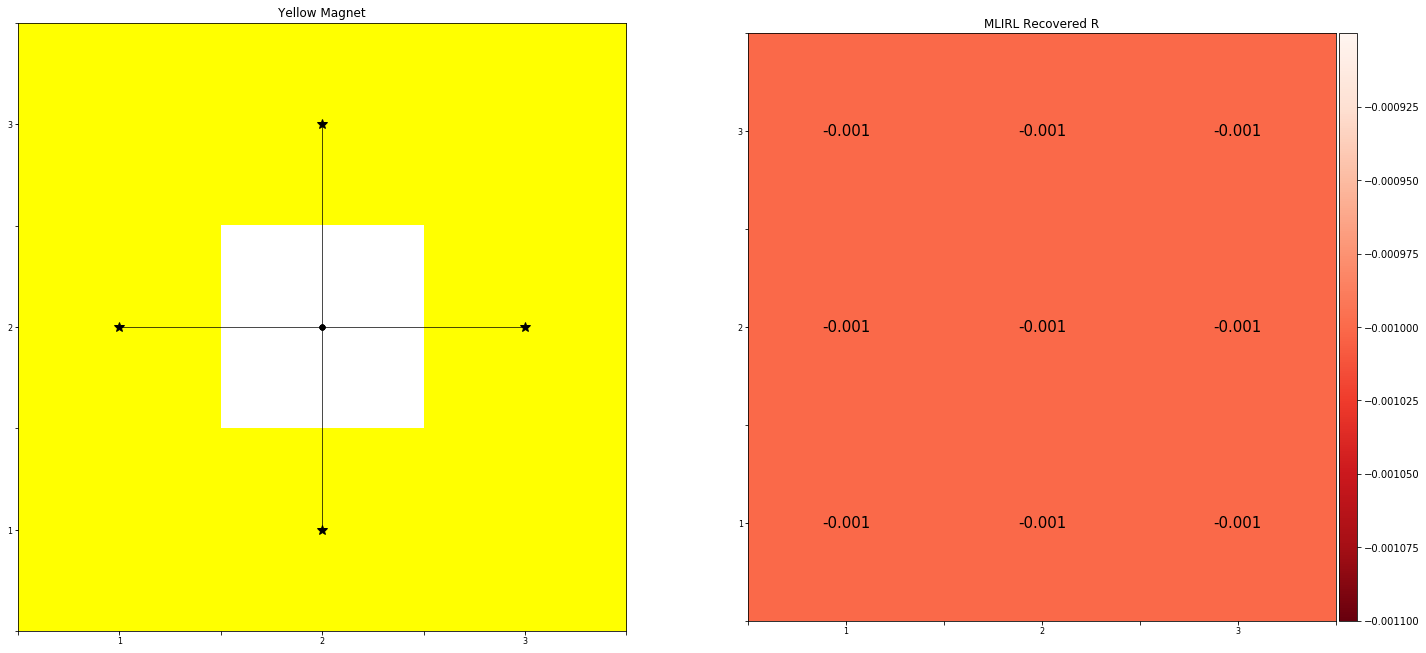

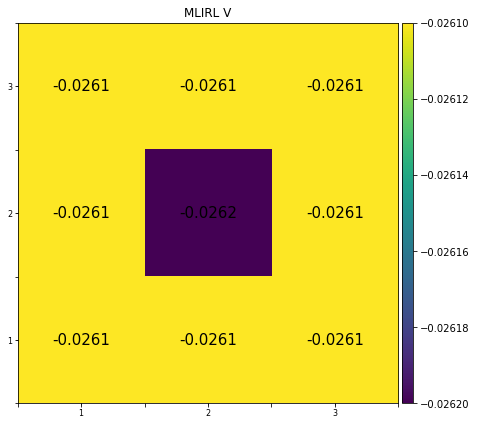

In [6]:
mlirl_params = dict(
    n_iter = 20,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.95,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 3,
    height = 3,
    cell_types = ['white', 'yellow'],
    cell_locs = [[(2,2)], np.inf],
    tau_s = [[(2,2),(3,2)], [(2,2),(2,1)], [(2,2),(2,3)], [(2,2),(1,2)]]
)
irl_problem = dict(
    mdp_params, 
    title="Yellow Magnet",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), results["V_grid"].round(4), irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

### Contradiction

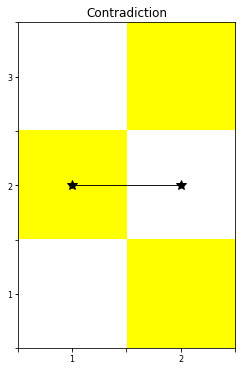

Training...
 				 	 white       yellow       	 white       yellow      
Iter: 0000, loss: 00002.772641, w: [+0.00171621 -0.01129667], dw: [-0.006348222 +0.007718951]
Iter: 0001, loss: 00002.772639, w: [+0.00163557 -0.01110651], dw: [-0.006198138 +0.007576346]
Iter: 0002, loss: 00002.772635, w: [+0.00148465 -0.01074855], dw: [-0.005927056 +0.007297188]
Iter: 0003, loss: 00002.772631, w: [+0.00127471 -0.01024592], dw: [-0.005539656 +0.006915182]
Iter: 0004, loss: 00002.772625, w: [+0.00101762 -0.00962194], dw: [-0.005065143 +0.006437302]
Iter: 0005, loss: 00002.772619, w: [+0.00072541 -0.00889977], dw: [-0.004519135 +0.005888283]
Iter: 0006, loss: 00002.772614, w: [+0.00040997 -0.00810193], dw: [-0.003918439 +0.005286694]
Iter: 0007, loss: 00002.772608, w: [+0.00008280 -0.00724999], dw: [-0.003281295 +0.004649878]
Iter: 0008, loss: 00002.772603, w: [-0.00024530 -0.00636425], dw: [-0.002627254 +0.003992736]
Iter: 0009, loss: 00002.772599, w: [-0.00056441 -0.00546351], dw: [-0.001969546 +0

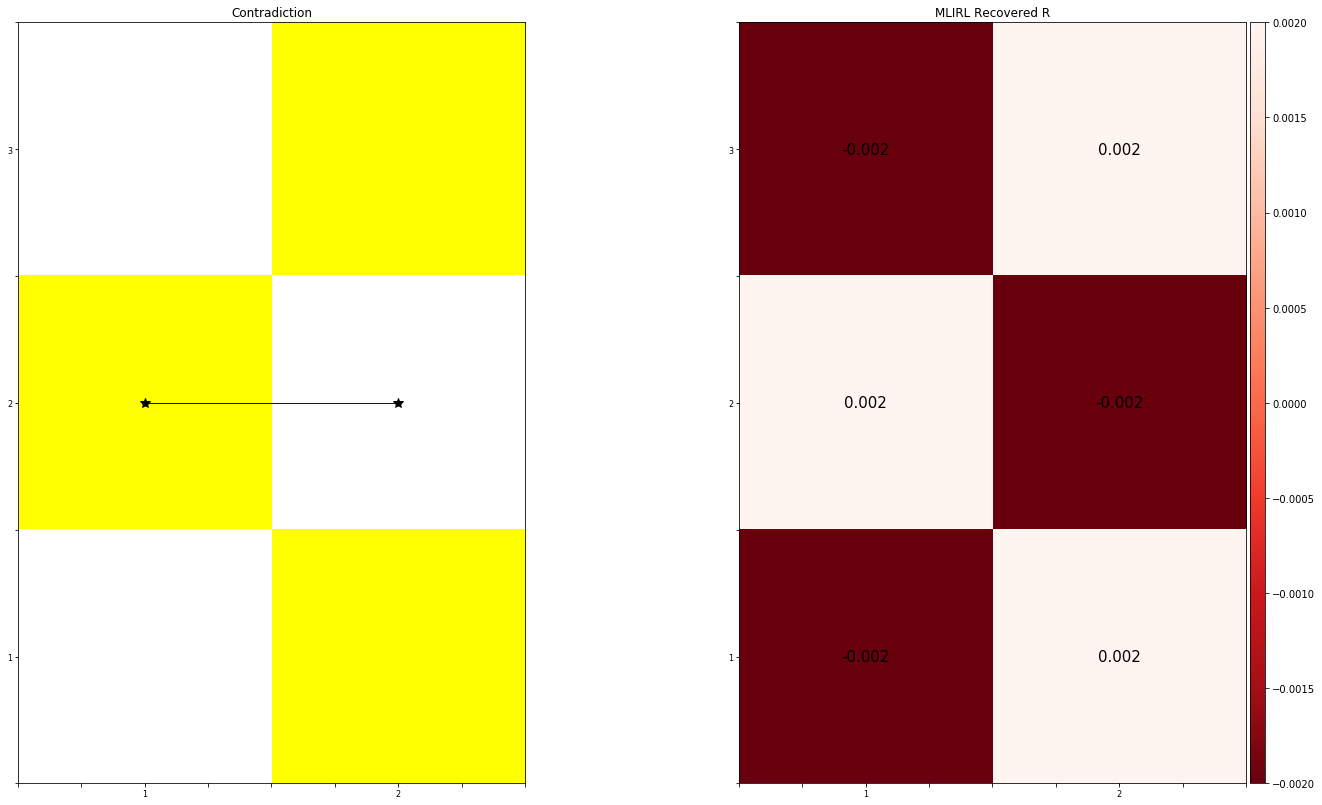

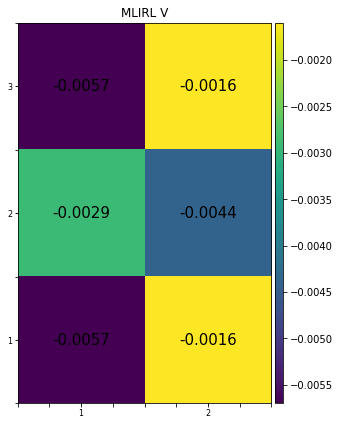

In [7]:
mlirl_params = dict(
    n_iter = 20,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.95,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 2,
    height = 3,
    cell_types = ['white', 'yellow'],
    cell_locs = [np.inf, [(1,2),(2,3),(2,1)]],
    tau_s = [[(2,2),(1,2)], [(1,2),(2,2)]]
)
irl_problem = dict(
    mdp_params, 
    title="Contradiction",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), results["V_grid"].round(4), irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

### Contradiction

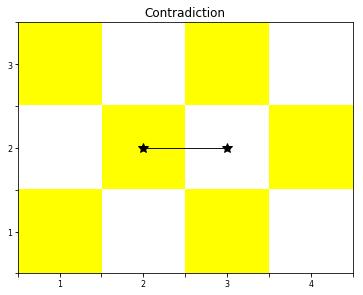

Training...
 				 	 white       yellow       	 white       yellow      
Iter: 0000, loss: 00002.772596, w: [-0.00399852 -0.00226681], dw: [+0.001840606 +0.000137374]
Iter: 0001, loss: 00002.772595, w: [-0.00394013 -0.00224277], dw: [+0.001823232 +0.000153735]
Iter: 0002, loss: 00002.772595, w: [-0.00382995 -0.00219716], dw: [+0.001791492 +0.000184715]
Iter: 0003, loss: 00002.772595, w: [-0.00367456 -0.00213230], dw: [+0.001748234 +0.000230268]
Iter: 0004, loss: 00002.772595, w: [-0.00348049 -0.00205030], dw: [+0.001691684 +0.000283182]
Iter: 0005, loss: 00002.772594, w: [-0.00325411 -0.00195317], dw: [+0.001631469 +0.000348791]
Iter: 0006, loss: 00002.772594, w: [-0.00300150 -0.00184272], dw: [+0.001560822 +0.000417113]
Iter: 0007, loss: 00002.772593, w: [-0.00272854 -0.00172073], dw: [+0.001488477 +0.000492170]
Iter: 0008, loss: 00002.772593, w: [-0.00244070 -0.00158880], dw: [+0.001409248 +0.000565767]
Iter: 0009, loss: 00002.772592, w: [-0.00214314 -0.00144853], dw: [+0.001332417 +0

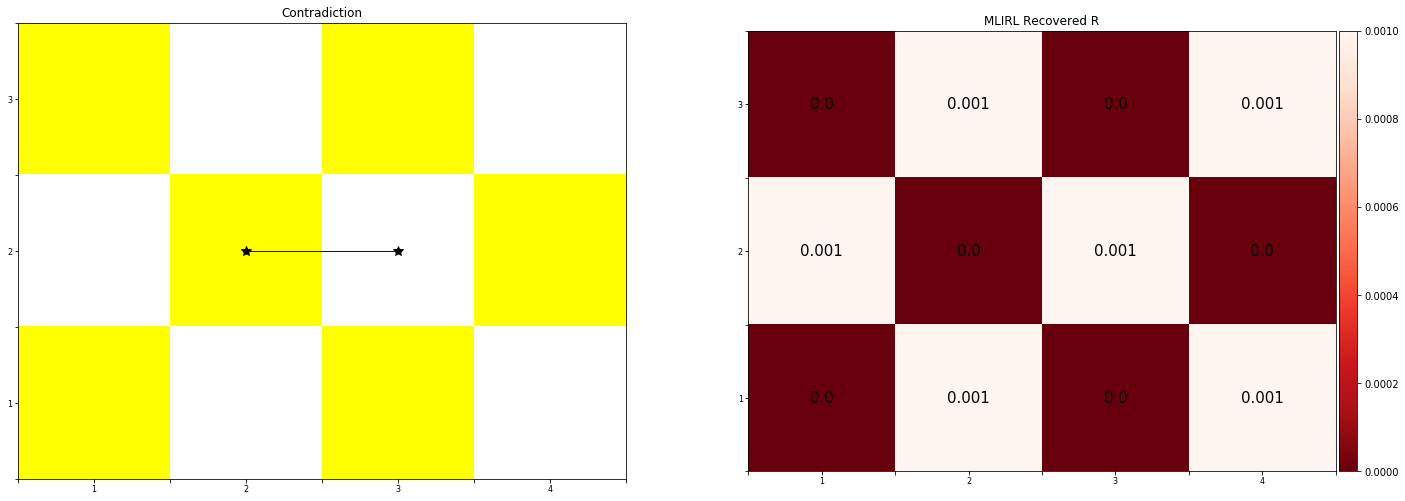

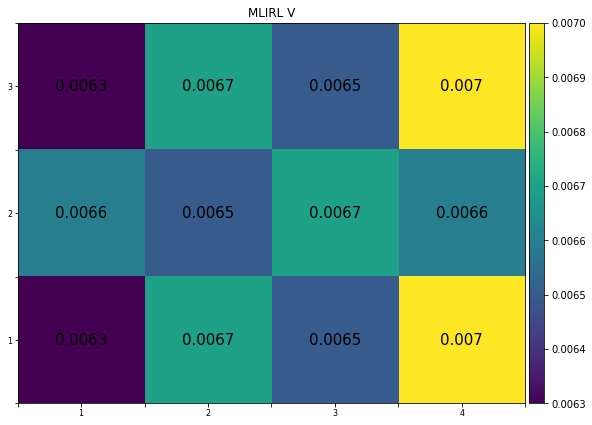

In [8]:
mlirl_params = dict(
    n_iter = 20,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.95,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 4,
    height = 3,
    cell_types = ['white', 'yellow'],
    cell_locs = [np.inf, [(1,3),(1,1),(2,2),(3,3),(3,1),(4,2)]],
    tau_s = [[(3,2),(2,2)], [(2,2),(3,2)]]
)
irl_problem = dict(
    mdp_params, 
    title="Contradiction",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), results["V_grid"].round(4), irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

### Vertical Spread

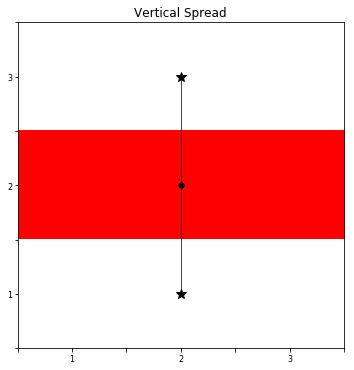

Training...
 				 	 white       red          	 white       red         
Iter: 0000, loss: 00002.775856, w: [-0.00219899 +0.00041468], dw: [+1.252093434 -1.246798873]
Iter: 0001, loss: 00002.744917, w: [+0.01034394 -0.01205745], dw: [+1.226802588 -1.221406579]
Iter: 0002, loss: 00002.688771, w: [+0.03379715 -0.03537587], dw: [+1.179597259 -1.173997045]
Iter: 0003, loss: 00002.614466, w: [+0.06636305 -0.06774865], dw: [+1.114817142 -1.108921885]
Iter: 0004, loss: 00002.529325, w: [+0.10615690 -0.10729589], dw: [+1.037942767 -1.031688452]
Iter: 0005, loss: 00002.439999, w: [+0.15128922 -0.15213233], dw: [+0.955044508 -0.948411822]
Iter: 0006, loss: 00002.351806, w: [+0.19994587 -0.20044792], dw: [+0.871772707 -0.864802957]
Iter: 0007, loss: 00002.268479, w: [+0.25045511 -0.25057548], dw: [+0.792508900 -0.785284579]
Iter: 0008, loss: 00002.192269, w: [+0.30133396 -0.30103737], dw: [+0.720023394 -0.712656438]
Iter: 0009, loss: 00002.124242, w: [+0.35131183 -0.35056928], dw: [+0.655652285 -0

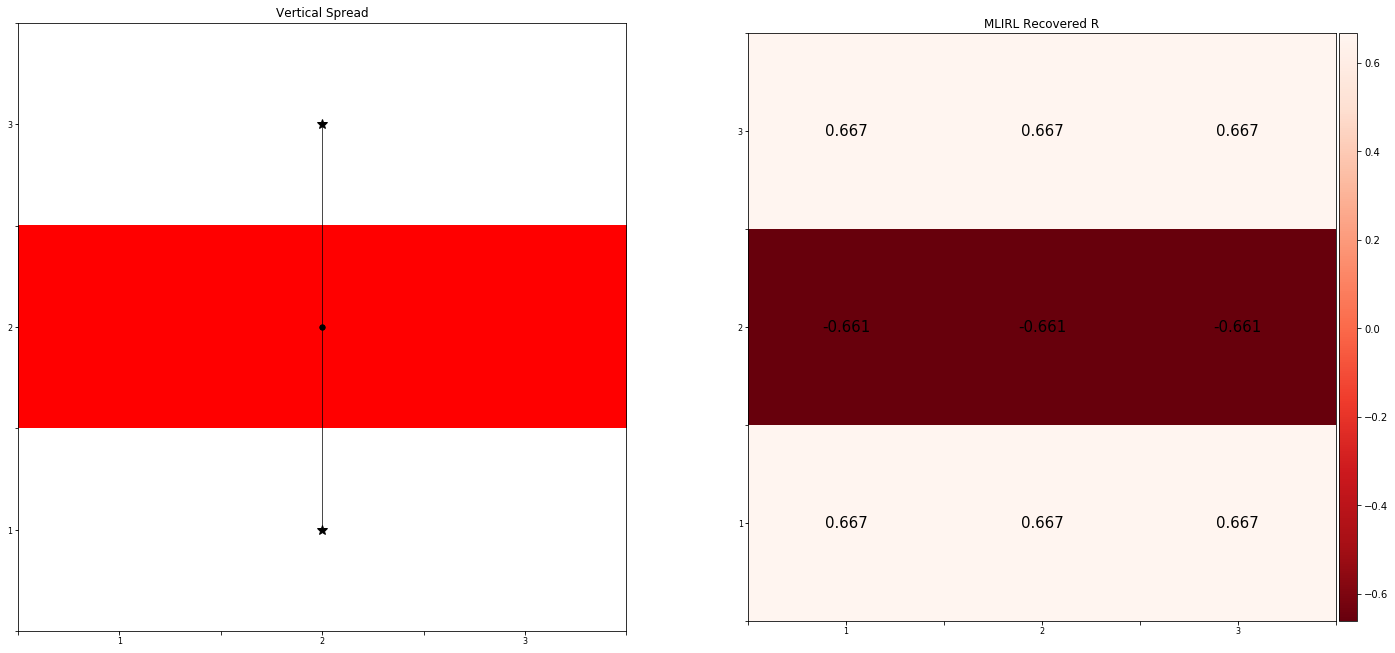

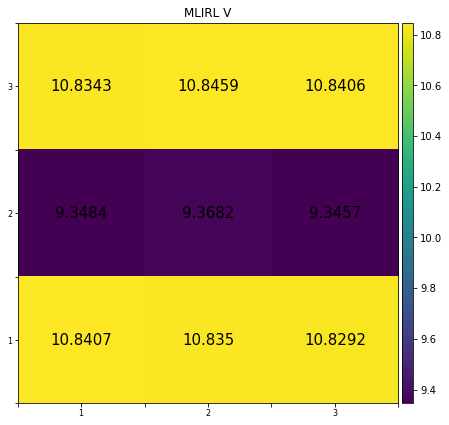

In [9]:
mlirl_params = dict(
    n_iter = 20,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.95,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 3,
    height = 3,
    cell_types = ['white', 'red'],
    cell_locs = [np.inf, [(i,2) for i in range(1,4)]],
    tau_s = [[(2,2),(2,3)], [(2,2),(2,1)]]
)
irl_problem = dict(
    mdp_params, 
    title="Vertical Spread",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), results["V_grid"].round(4), irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

### Directions

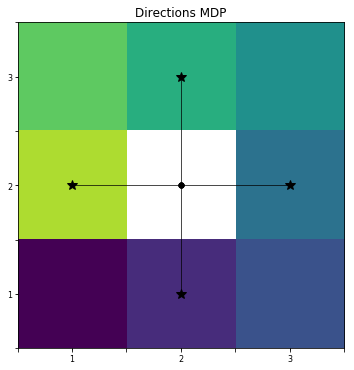

Training...
 				 	 white                 0           1           2           3           4           5           6           7  	 white                 0           1           2           3           4           5           6           7 
Iter: 0000, loss: 00005.545185, w: [+0.00245865 +0.00300040 -0.00757648 +0.01588486 -0.01024049 +0.00255382 -0.00119612 -0.00177172 -0.00293161], dw: [+0.000028161 -0.000854545 -0.004737819 -0.001991915 +0.000615513 +0.000905055 +0.001372110 +0.001858571 +0.002785867]
Iter: 0001, loss: 00005.545184, w: [+0.00243434 +0.00296185 -0.00754810 +0.01570609 -0.01013193 +0.00253733 -0.00117044 -0.00173542 -0.00287444], dw: [+0.000026553 -0.000810173 -0.004530239 -0.001880624 +0.000635234 +0.000857677 +0.001249274 +0.001756771 +0.002679981]
Iter: 0002, loss: 00005.545183, w: [+0.00238839 +0.00288943 -0.00749237 +0.01536933 -0.00992656 +0.00250570 -0.00112313 -0.00166782 -0.00276743], dw: [+0.000022705 -0.000728747 -0.004146633 -0.001676493 +0.000669326 +0.000

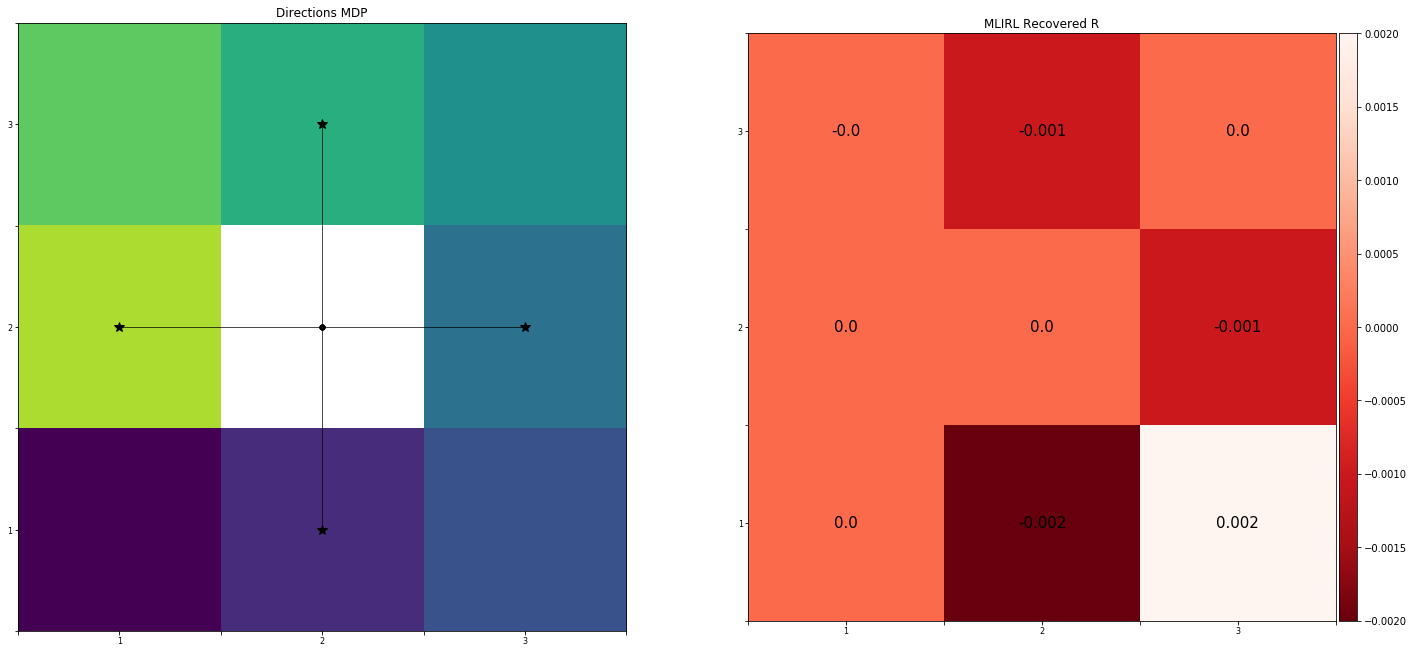

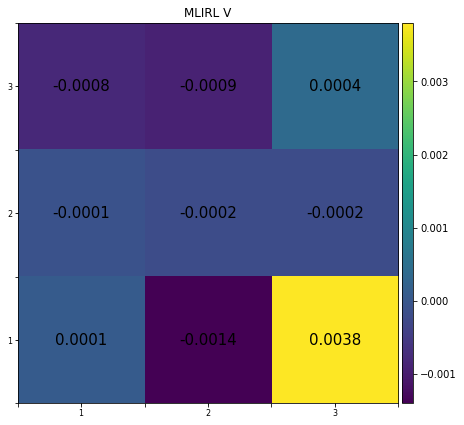

In [10]:
mlirl_params = dict(
    n_iter = 20,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.95,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 3,
    height = 3,
    cell_types = ['white'] + list(range(0,8)),
    cell_locs = [[(2,2)], [(1,1)], [(2,1)], [(3,1)], [(3,2)], [(3,3)], [(2,3)], [(1,3)], [(1,2)]],
    tau_s = [[(2,2),(3,2)], [(2,2),(2,3)], [(2,2),(1,2)], [(2,2),(2,1)]]
)
irl_problem = dict(
    mdp_params, 
    title="Directions",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), results["V_grid"].round(4), irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

### Speed Bump MDP

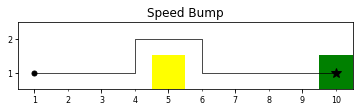

Training...
 				 	 white       yellow      green        	 white       yellow      green       
Iter: 0000, loss: 00015.191551, w: [-0.02556189 +0.01897787 +0.00004463], dw: [-2.984348059 -0.932587028 +3.993515491]
Iter: 0001, loss: 00014.895601, w: [-0.05514975 +0.00946222 +0.03997933], dw: [-4.044856071 -1.107902408 +5.236240864]
Iter: 0002, loss: 00013.907928, w: [-0.12167589 -0.01027551 +0.12788318], dw: [-6.701017380 -1.407267213 +8.188774109]
Iter: 0003, loss: 00011.652241, w: [-0.24734282 -0.04200938 +0.28760555], dw: [-6.256907463 -1.356185317 +7.658014297]
Iter: 0004, loss: 00009.465178, w: [-0.42053869 -0.08371162 +0.50505978], dw: [-3.332450390 -1.186194420 +4.561244488]
Iter: 0005, loss: 00008.215525, w: [-0.60553408 -0.13226847 +0.74133039], dw: [-1.177866697 -1.105303645 +2.334809780]
Iter: 0006, loss: 00007.694480, w: [-0.77775323 -0.18570000 +0.96990871], dw: [+0.031781286 -1.025735140 +1.053117037]
Iter: 0007, loss: 00007.555184, w: [-0.92465514 -0.24218872 +1.17646134

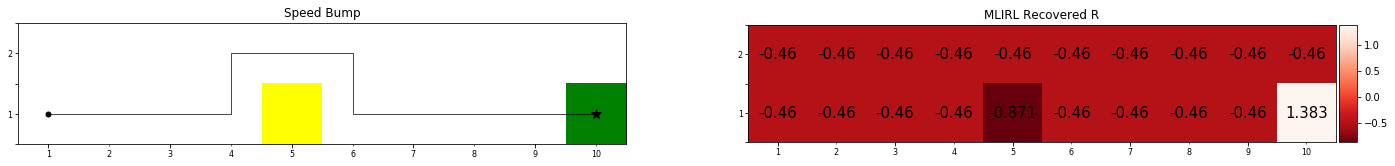

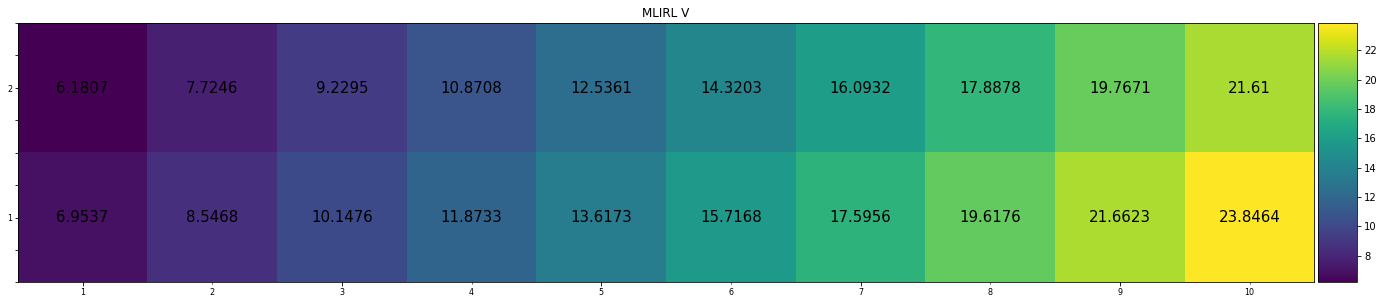

In [11]:
mlirl_params = dict(
    n_iter = 20,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.95,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 10,
    height = 2,
    cell_types = ['white', "yellow", "green"],
    cell_locs = [np.inf, [(5,1)], [(10,1)]],
    tau_s = [[(i,1) for i in range(1,5)] + [(4,2), (5,2), (6,2)] + [(i,1) for i in range(6,11)]]
)
irl_problem = dict(
    mdp_params, 
    title="Speed Bump",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), results["V_grid"].round(4), irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

### Ripples

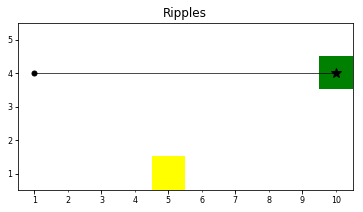

Training...
 				 	 white       yellow      green        	 white       yellow      green       
Iter: 0000, loss: 00012.520787, w: [-0.00502544 +0.00378397 -0.01693677], dw: [-3.122643471 -0.355132729 +3.389452219]
Iter: 0001, loss: 00012.286491, w: [-0.03620162 +0.00019480 +0.01712712], dw: [-3.584198952 -0.465612441 +4.219974995]
Iter: 0002, loss: 00011.601020, w: [-0.09974015 -0.00769352 +0.08981310], dw: [-5.392736912 -0.810373485 +7.166114807]
Iter: 0003, loss: 00009.164065, w: [-0.20985480 -0.02281981 +0.22599350], dw: [-11.215734482 -1.483698130 +14.408244133]
Iter: 0004, loss: 00005.093158, w: [-0.41901678 -0.05104226 +0.49037838], dw: [-6.888333321 -0.017807286 +3.228383064]
Iter: 0005, loss: 00003.192180, w: [-0.67195570 -0.07611011 +0.75570476], dw: [-4.873510361 -0.000464068 +0.543220997]
Iter: 0006, loss: 00002.046311, w: [-0.94161630 -0.09791471 +0.99237370], dw: [-3.799081564 -0.005525910 -0.512383640]
Iter: 0007, loss: 00001.282745, w: [-1.21288550 -0.11661497 +1.190328

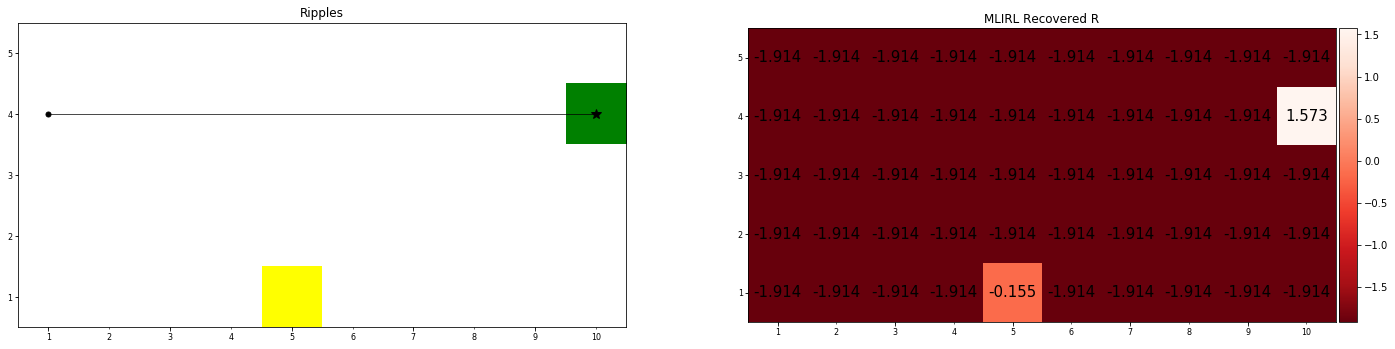

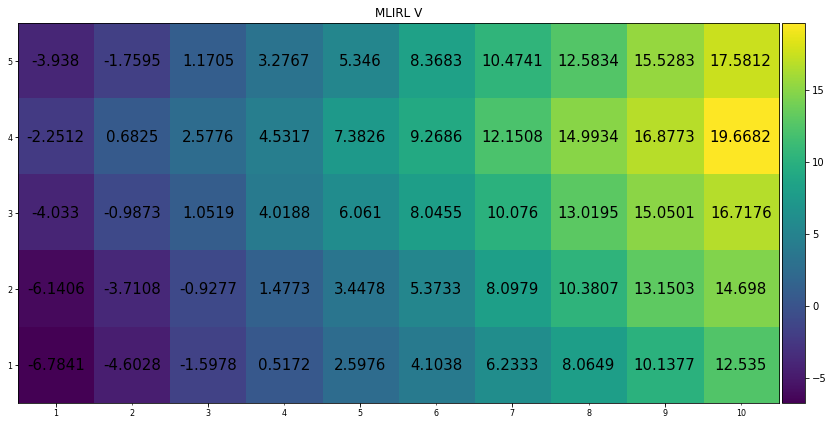

In [12]:
mlirl_params = dict(
    n_iter = 10,
    n_vi_iter = 20,
    dtype = torch.float,
    gamma = 0.9999,
    boltzmann_beta = 1.,
    optimize r_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
yi = 4
mdp_params = dict(
    width = 10,
    height = 5,
    cell_types = ['white', "yellow", "green"],
    cell_locs = [np.inf, [(5,1)], [(10,4)]],
    tau_s = [[(i,yi) for i in range(1,5)] + [(5,yi)] + [(i,yi) for i in range(6,11)]]
    #tau_s = [[(i,yi) for i in range(1,5)] + [(4,yi+1), (5,yi+1), (6,yi+1)] + [(i,yi) for i in range(6,11)]]
)
irl_problem = dict(
    mdp_params, 
    title="Ripples",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), results["V_grid"].round(4), irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

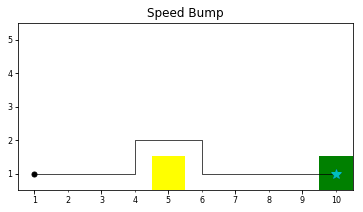

Training...
 				 	 white       yellow      green        	 white       yellow      green       
Iter: 0000, loss: 00015.254758, w: [+0.00419885 -0.00158858 -0.02259577], dw: [-0.121510342 -0.217335373 +0.237192124]
Iter: 0001, loss: 00015.242391, w: [-0.00837207 -0.02316326 +0.00338302], dw: [-0.121312156 -0.216847822 +0.236712411]
Iter: 0002, loss: 00015.220221, w: [-0.03097991 -0.06194893 +0.05009687], dw: [-0.120947465 -0.215974525 +0.235845387]
Iter: 0003, loss: 00015.191581, w: [-0.06032372 -0.11225858 +0.11071418], dw: [-0.120454170 -0.214848056 +0.234711871]
Iter: 0004, loss: 00015.160113, w: [-0.09274618 -0.16779622 +0.17766953], dw: [-0.119885400 -0.213612765 +0.233448923]
Iter: 0005, loss: 00015.129348, w: [-0.12464033 -0.22236176 +0.24350728], dw: [-0.119300589 -0.212407932 +0.232196078]
Iter: 0006, loss: 00015.102336, w: [-0.15281108 -0.27047536 +0.30163014], dw: [-0.118761756 -0.211353764 +0.231081143]
Iter: 0007, loss: 00015.081409, w: [-0.17475982 -0.30786544 +0.34688580

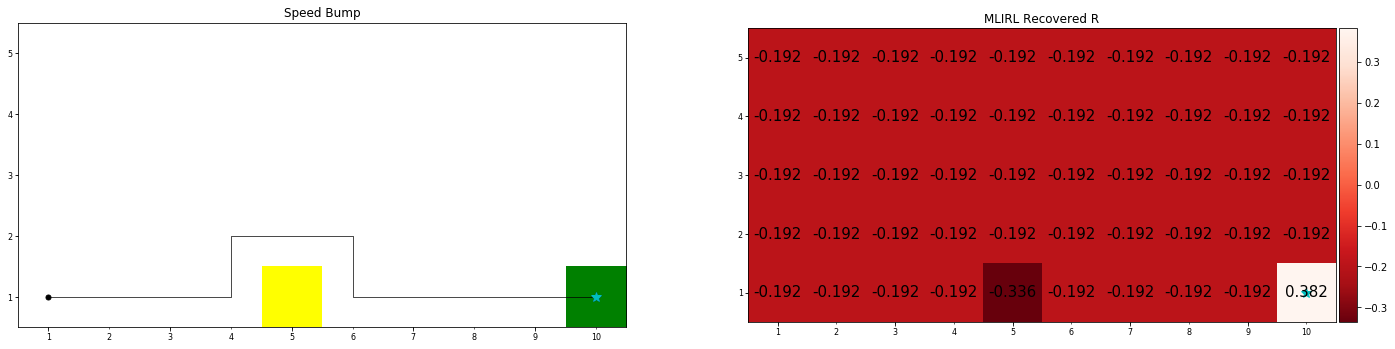

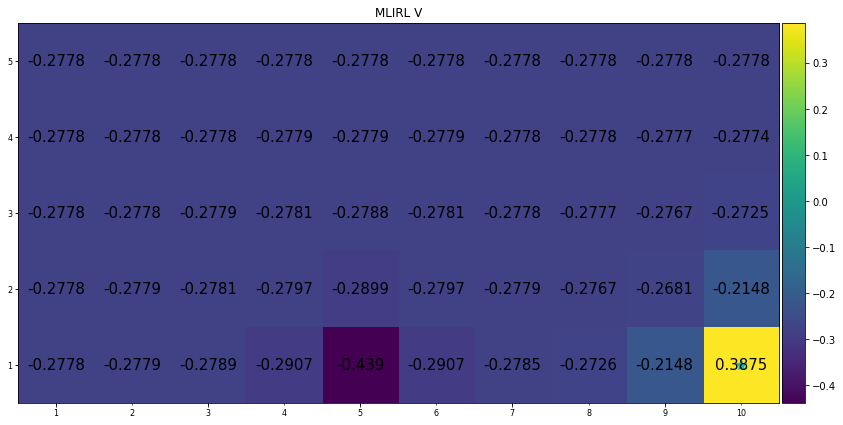

In [77]:
mlirl_params = dict(
    n_iter = 10,
    n_vi_iter = 10,
    dtype = torch.float,
    gamma = 0.30,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.1, momentum=0.9, weight_decay=1.)
)
yi = 1
mdp_params = dict(
    width = 10,
    height = 5,
    cell_types = ['white', "yellow"],
    cell_locs = [np.inf, [(5,1)]],
    goal_types = ["green"],
    goal_locs = [(10, yi)],
    tau_s = [[(i,yi) for i in range(1,5)] + [(4,yi+1), (5,yi+1), (6,yi+1)] + [(i,yi) for i in range(6,11)]]
)
irl_problem = dict(
    mdp_params, 
    title="Speed Bump",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), results["V_grid"].round(4), irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

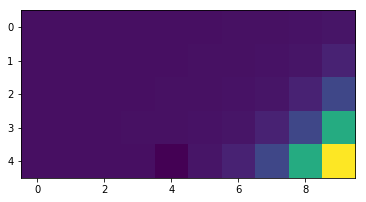

In [73]:
nvmdp = results["nvmdp"]
nvmdp._reset_rewards([-1.559, -1.669], [0.661])
nvmdp.value_iter.gamma = 0.30
nvmdp.run_value_iteration()
plt.imshow(nvmdp.get_value_grid())

In [51]:
# nvmdp = results["nvmdp"]
# nvmdp._reset_rewards([-0.397, -2], [0.477])
# nvmdp.run_value_iteration()
# plt.imshow(nvmdp.get_value_grid())

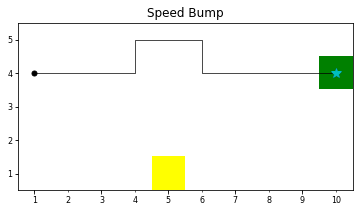

Training...
 				 	 white       yellow      green        	 white       yellow      green       
Iter: 0000, loss: 00015.255113, w: [+0.01250372 -0.00161881 -0.00650418], dw: [-0.344572723 -0.000325447 +0.241429061]
Iter: 0001, loss: 00015.236852, w: [-0.02320392 -0.00148948 +0.01828914], dw: [-0.343541622 -0.000332046 +0.240711167]
Iter: 0002, loss: 00015.204168, w: [-0.08737458 -0.00125733 +0.06284533], dw: [-0.341669321 -0.000344158 +0.239409104]
Iter: 0003, loss: 00015.162073, w: [-0.17055763 -0.00095708 +0.12060228], dw: [-0.339208871 -0.000360357 +0.237698063]
Iter: 0004, loss: 00015.116006, w: [-0.26228750 -0.00062719 +0.18429312], dw: [-0.336450756 -0.000378892 +0.235780999]
Iter: 0005, loss: 00015.071188, w: [-0.35226071 -0.00030545 +0.24676365], dw: [-0.333701491 -0.000397778 +0.233869687]
Iter: 0006, loss: 00015.032081, w: [-0.43138069 -0.00002512 +0.30169773], dw: [-0.331247061 -0.000414980 +0.232163489]
Iter: 0007, loss: 00015.002033, w: [-0.49257529 +0.00018819 +0.34418496

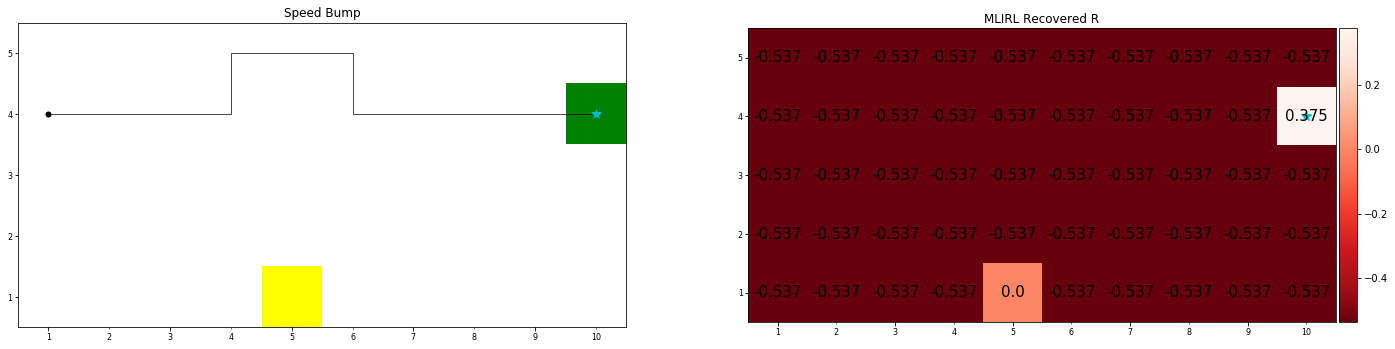

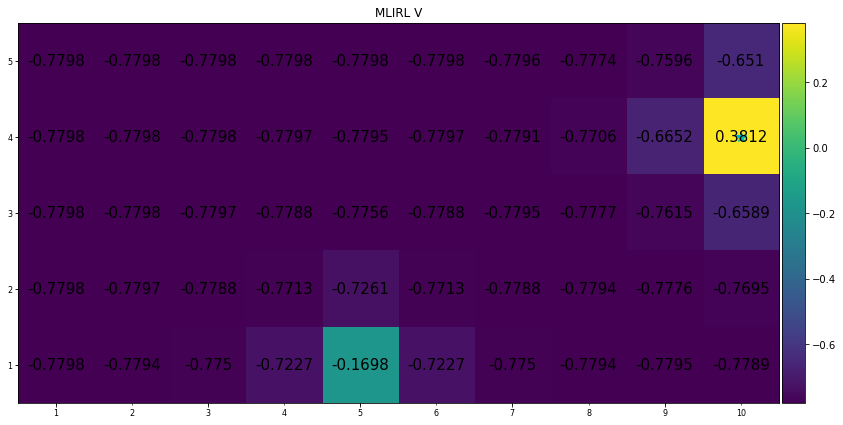

In [78]:
mlirl_params = dict(
    n_iter = 10,
    n_vi_iter = 10,
    dtype = torch.float,
    gamma = 0.30,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.1, momentum=0.9, weight_decay=1.)
)
yi = 4
mdp_params = dict(
    width = 10,
    height = 5,
    cell_types = ['white', "yellow"],
    cell_locs = [np.inf, [(5,1)]],
    goal_types = ["green"],
    goal_locs = [(10, yi)],
    tau_s = [[(i,yi) for i in range(1,5)] + [(4,yi+1), (5,yi+1), (6,yi+1)] + [(i,yi) for i in range(6,11)]]
)
irl_problem = dict(
    mdp_params, 
    title="Speed Bump",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), results["V_grid"].round(4), irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

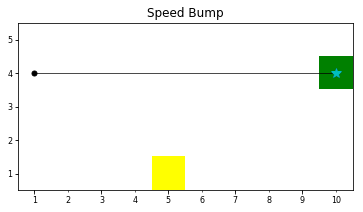

Training...
 				 	 white       yellow      green        	 white       yellow      green       
Iter: 0000, loss: 00012.479146, w: [+0.01032113 +0.02336465 +0.00443246], dw: [-0.344078630 -0.000646168 +0.241307318]
Iter: 0001, loss: 00012.461260, w: [-0.02511885 +0.02096356 +0.02811995], dw: [-0.343060017 -0.000658282 +0.240603119]
Iter: 0002, loss: 00012.429252, w: [-0.08880894 +0.01664041 +0.07068700], dw: [-0.341213644 -0.000680487 +0.239326045]
Iter: 0003, loss: 00012.388018, w: [-0.17137048 +0.01101748 +0.12586126], dw: [-0.338787168 -0.000710118 +0.237648427]
Iter: 0004, loss: 00012.342891, w: [-0.26241755 +0.00478408 +0.18669680], dw: [-0.336069286 -0.000743931 +0.235769451]
Iter: 0005, loss: 00012.298984, w: [-0.35172507 -0.00137878 +0.24635606], dw: [-0.333360195 -0.000778284 +0.233896807]
Iter: 0006, loss: 00012.260668, w: [-0.43026537 -0.00686530 +0.29880345], dw: [-0.330941111 -0.000809480 +0.232225671]
Iter: 0007, loss: 00012.231227, w: [-0.49101919 -0.01119759 +0.33934835

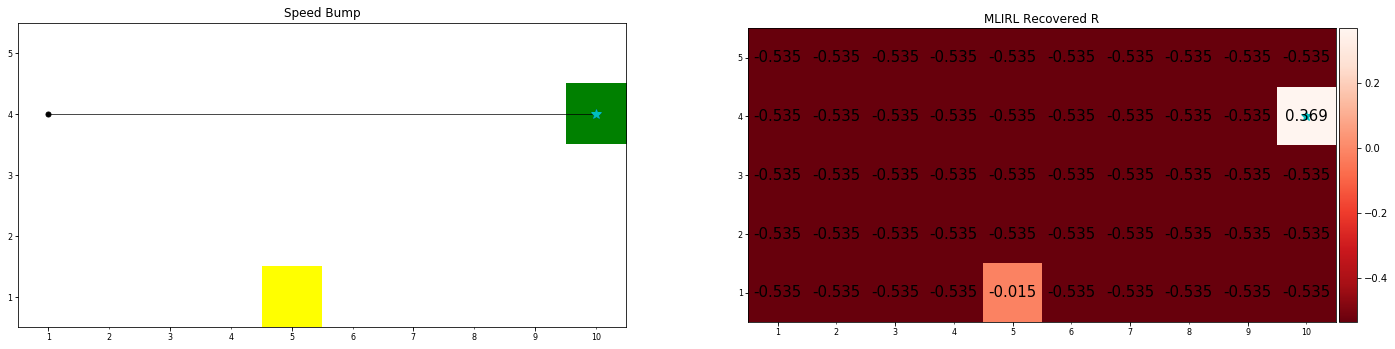

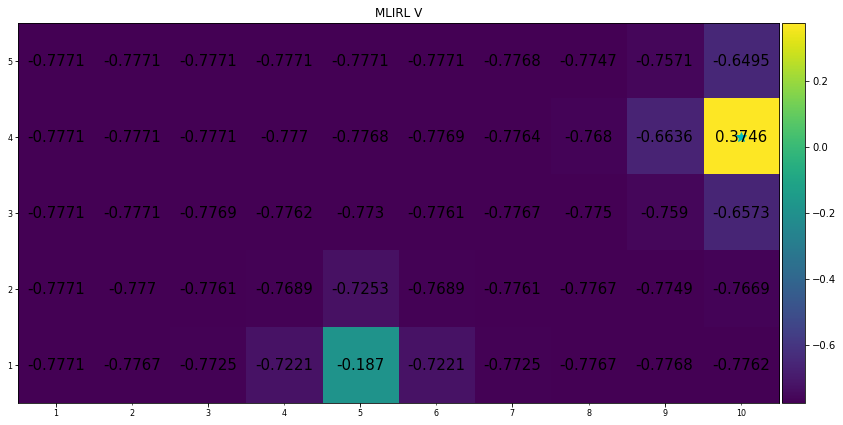

In [80]:
mlirl_params = dict(
    n_iter = 10,
    n_vi_iter = 10,
    dtype = torch.float,
    gamma = 0.30,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.1, momentum=0.9, weight_decay=1.)
)
yi = 4
mdp_params = dict(
    width = 10,
    height = 5,
    cell_types = ['white', "yellow"],
    cell_locs = [np.inf, [(5,1)]],
    goal_types = ["green"],
    goal_locs = [(10, yi)],
    tau_s = [[(i,yi) for i in range(1,11)]]
)
irl_problem = dict(
    mdp_params, 
    title="Speed Bump",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), results["V_grid"].round(4), irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

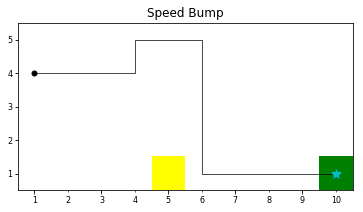

Training...
 				 	 white       yellow      green        	 white       yellow      green       
Iter: 0000, loss: 00018.018782, w: [-0.01159079 -0.00761899 -0.00234443], dw: [-0.257419050 -0.080756351 +0.236723050]
Iter: 0001, loss: 00018.006226, w: [-0.03617362 -0.01493272 +0.02156232], dw: [-0.256110400 -0.081141204 +0.236076325]
Iter: 0002, loss: 00017.983786, w: [-0.08029184 -0.02813593 +0.06452979], dw: [-0.253747106 -0.081834517 +0.234907001]
Iter: 0003, loss: 00017.954933, w: [-0.13734376 -0.04538868 +0.12023824], dw: [-0.250662804 -0.082735330 +0.233378798]
Iter: 0004, loss: 00017.923435, w: [-0.20002240 -0.06465082 +0.18168989], dw: [-0.247240543 -0.083728790 +0.231678501]
Iter: 0005, loss: 00017.892883, w: [-0.26115498 -0.08389454 +0.24199525], dw: [-0.243870080 -0.084697977 +0.229997739]
Iter: 0006, loss: 00017.866318, w: [-0.31444582 -0.10129423 +0.29507032], dw: [-0.240909100 -0.085536703 +0.228512391]
Iter: 0007, loss: 00017.845999, w: [-0.35505390 -0.11537819 +0.33618209

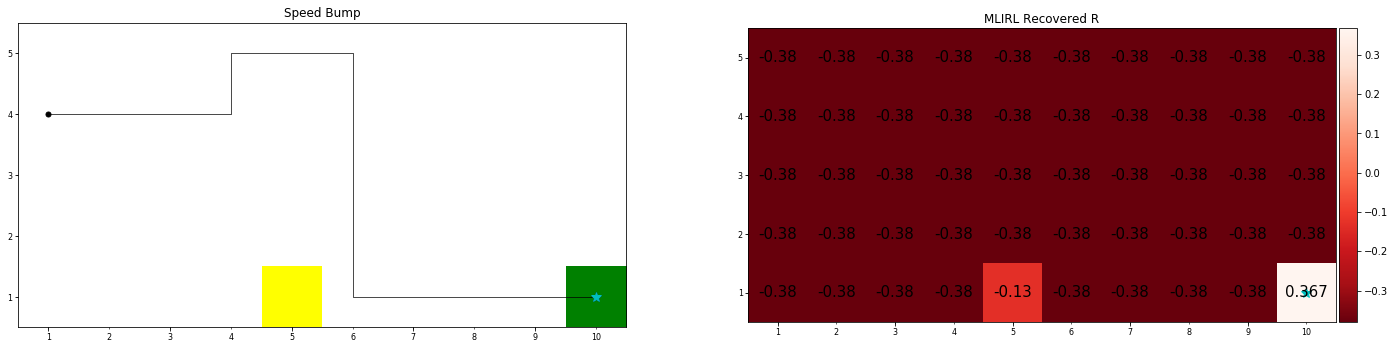

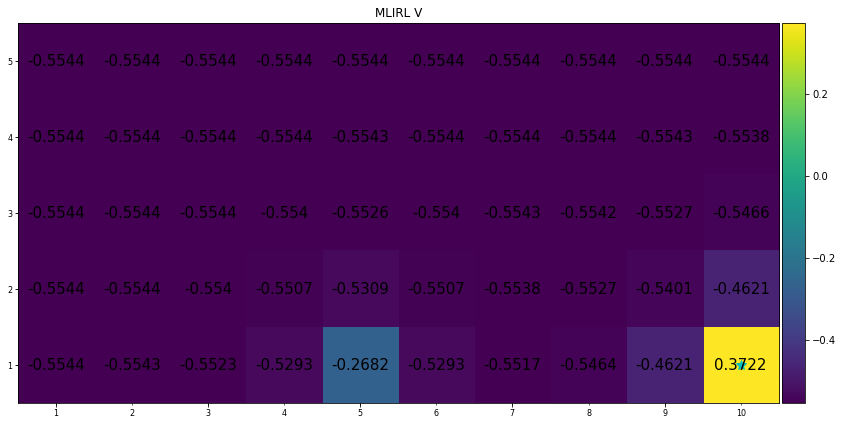

In [82]:
mlirl_params = dict(
    n_iter = 10,
    n_vi_iter = 10,
    dtype = torch.float,
    gamma = 0.30,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.1, momentum=0.9, weight_decay=1.)
)
yi = 4
mdp_params = dict(
    width = 10,
    height = 5,
    cell_types = ['white', "yellow"],
    cell_locs = [np.inf, [(5,1)]],
    goal_types = ["green"],
    goal_locs = [(10, 1)],
    tau_s = [[(i,yi) for i in range(1,5)] + [(4,yi+1), (5,yi+1), (6,yi+1)] + [(6,3),(6,2),(6,1)] + [(i,1) for i in range(7,11)]]
)
irl_problem = dict(
    mdp_params, 
    title="Speed Bump",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), results["V_grid"].round(4), irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

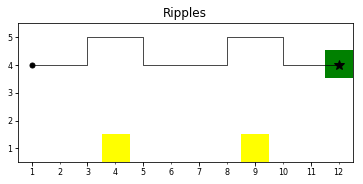

Training...
 				 	 white       yellow      green        	 white       yellow      green       
Iter: 0000, loss: 00020.730837, w: [+0.00086431 -0.00214688 +0.02307208], dw: [-0.111041546 -0.311489880 +2.809729338]
Iter: 0001, loss: 00019.494423, w: [-0.01023984 -0.03329587 +0.30404502], dw: [-2.547539711 -0.335529745 +6.149870396]
Iter: 0002, loss: 00013.457169, w: [-0.26499382 -0.06684884 +0.91903210], dw: [-3.612049818 -0.272753894 +5.879601479]
Iter: 0003, loss: 00012.343438, w: [-0.62619877 -0.09412424 +1.50699234], dw: [-1.517322183 -0.037642226 -2.241779089]
Iter: 0004, loss: 00011.595565, w: [-0.77793097 -0.09788845 +1.28281438], dw: [-1.843538284 +0.007530253 -1.572822332]
Iter: 0005, loss: 00011.659966, w: [-0.96228480 -0.09713543 +1.12553215], dw: [+1.952602744 -3.427456617 +4.135700226]
Iter: 0006, loss: 00012.184042, w: [-0.76702452 -0.43988109 +1.53910220], dw: [-1.626590133 -0.037337631 -2.557921648]
Iter: 0007, loss: 00011.378337, w: [-0.92968357 -0.44361484 +1.28331006

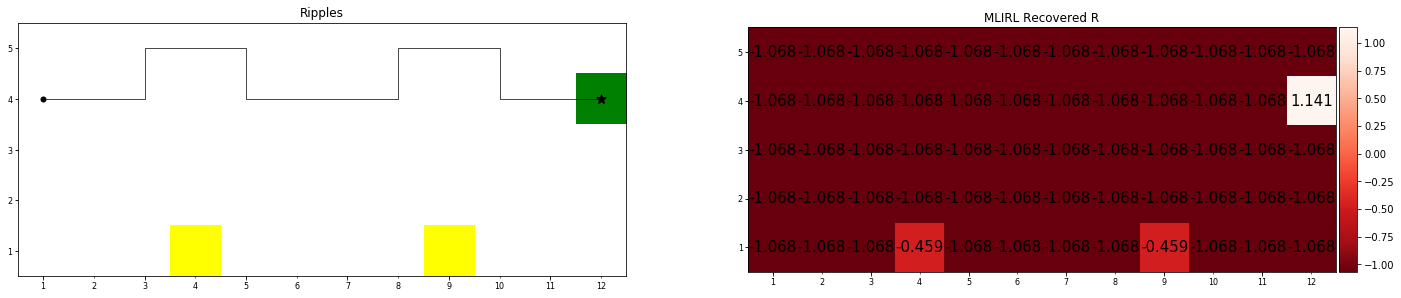

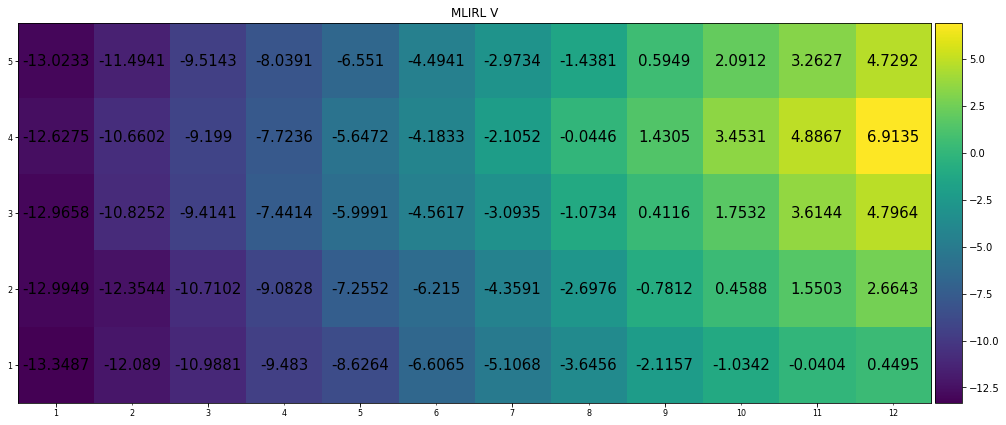

In [15]:
mlirl_params = dict(
    n_iter = 10,
    n_vi_iter = 10,
    dtype = torch.float,
    gamma = 0.99,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.1, momentum=0., weight_decay=0.)
)
mdp_params = dict(
    width = 12,
    height = 5,
    cell_types = ['white', "yellow", "green"],
    cell_locs = [np.inf, [(4,1), (9,1)], [(12,4)]],
    tau_s = [[(i,4) for i in range(1,4)] + [(3,5), (4,5), (5,5)] + [(5,4), (6,4), (7,4), (8,4)] +[(8,5), (9,5), (10,5)] + [(10,4), (11,4), (12,4)]]
)
irl_problem = dict(
    mdp_params, 
    title="Ripples",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), results["V_grid"].round(4), irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

### Suspicious Entry

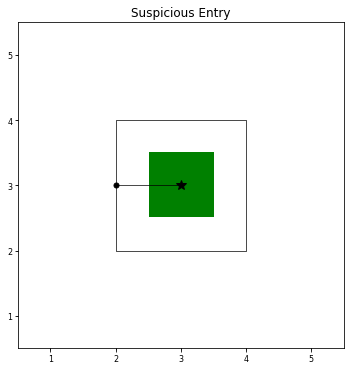

Training...
 				 	 white       green        	 white       green       
Iter: 0000, loss: 00012.466919, w: [-0.01029556 +0.01012384], dw: [-0.468643636 +0.488505781]
Iter: 0001, loss: 00012.462424, w: [-0.01487904 +0.01490766], dw: [-0.470407844 +0.490278572]
Iter: 0002, loss: 00012.453869, w: [-0.02355946 +0.02396680], dw: [-0.473791361 +0.493683904]
Iter: 0003, loss: 00012.441629, w: [-0.03587416 +0.03681721], dw: [-0.478695780 +0.498598784]
Iter: 0004, loss: 00012.426037, w: [-0.05138560 +0.05300039], dw: [-0.484952569 +0.504870713]
Iter: 0005, loss: 00012.407390, w: [-0.06968157 +0.07208395], dw: [-0.492336661 +0.512250066]
Iter: 0006, loss: 00012.385977, w: [-0.09037449 +0.09366082], dw: [-0.500443220 +0.520317435]
Iter: 0007, loss: 00012.362088, w: [-0.11309881 +0.11734656], dw: [-0.508581460 +0.528384507]
Iter: 0008, loss: 00012.336056, w: [-0.13750552 +0.14277411], dw: [-0.515721560 +0.535385728]
Iter: 0009, loss: 00012.308287, w: [-0.16325371 +0.16958502], dw: [-0.520304263 +0

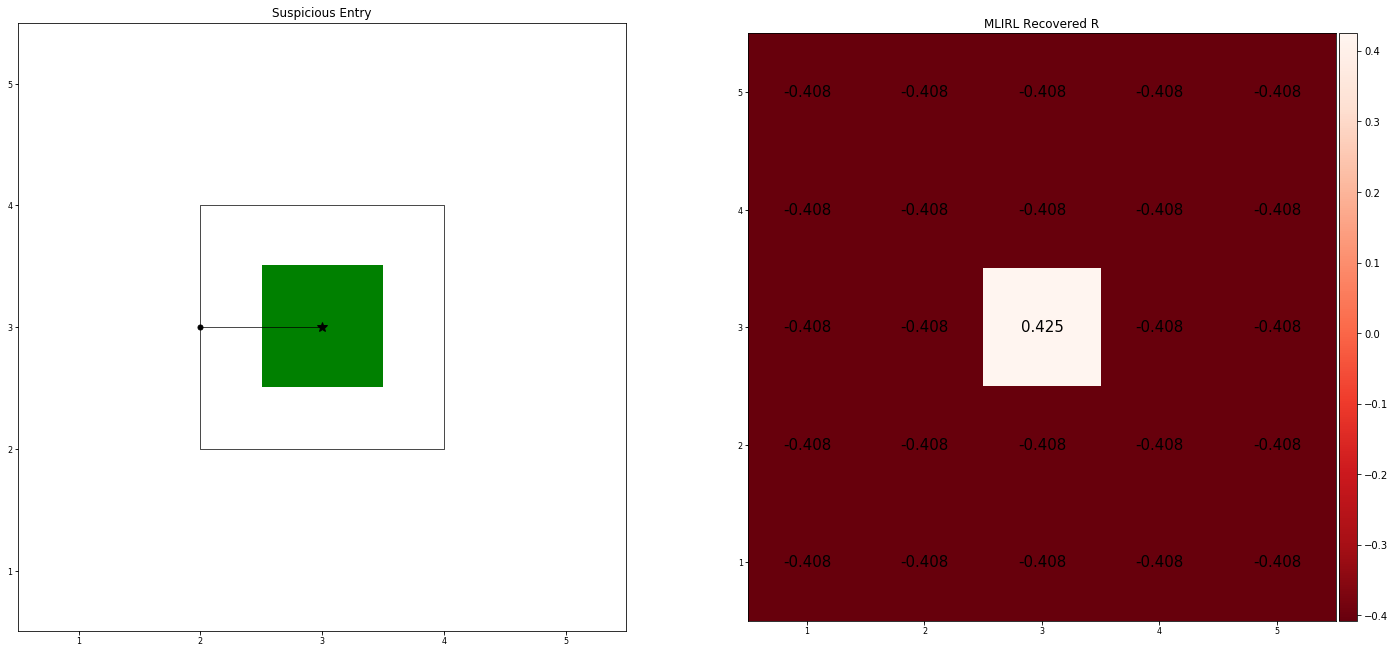

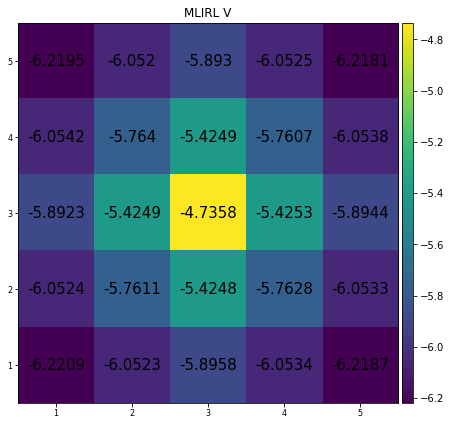

In [16]:
mlirl_params = dict(
    n_iter = 20,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.95,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 5,
    height = 5,
    cell_types = ['white', "green"],
    cell_locs = [np.inf, [(3,3)]],
    tau_s = [[(2,3),(2,4),(3,4),(4,4),(4,3),(4,2),(3,2),(2,2),(2,3),(3,3)]]
)
irl_problem = dict(
    mdp_params, 
    title="Suspicious Entry", 
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)

results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), results["V_grid"].round(4), irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

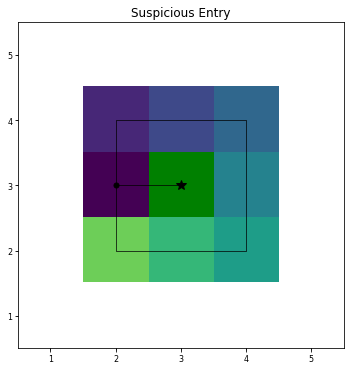

Training...
 				 	 white       green                 0           1           2           3           4           5           6           7  	 white       green                 0           1           2           3           4           5           6           7 
Iter: 0000, loss: 00012.479784, w: [-0.00172022 -0.01798756 -0.00338431 -0.00637593 +0.00639495 -0.01087248 -0.00031155 -0.00170523 +0.00517615 +0.00264081], dw: [-5.693936348 +0.483108103 +0.519428313 +0.286290854 +0.786240220 +0.809759855 +0.950054049 +0.813916743 +0.787199497 +0.277891815]
Iter: 0001, loss: 00012.125776, w: [-0.05864237 -0.01297660 +0.00184381 -0.00344926 +0.01419340 -0.00266616 +0.00919211 +0.00645099 +0.01299639 +0.00539332], dw: [-5.314347267 +0.450891346 +0.456889272 +0.247994706 +0.741420388 +0.765313447 +0.921334684 +0.768416166 +0.741687596 +0.239118353]
Iter: 0002, loss: 00011.553264, w: [-0.16242936 -0.00382806 +0.01109958 +0.00169918 +0.02848428 +0.01239933 +0.02686682 +0.02141124 +0.02732151 +0.0

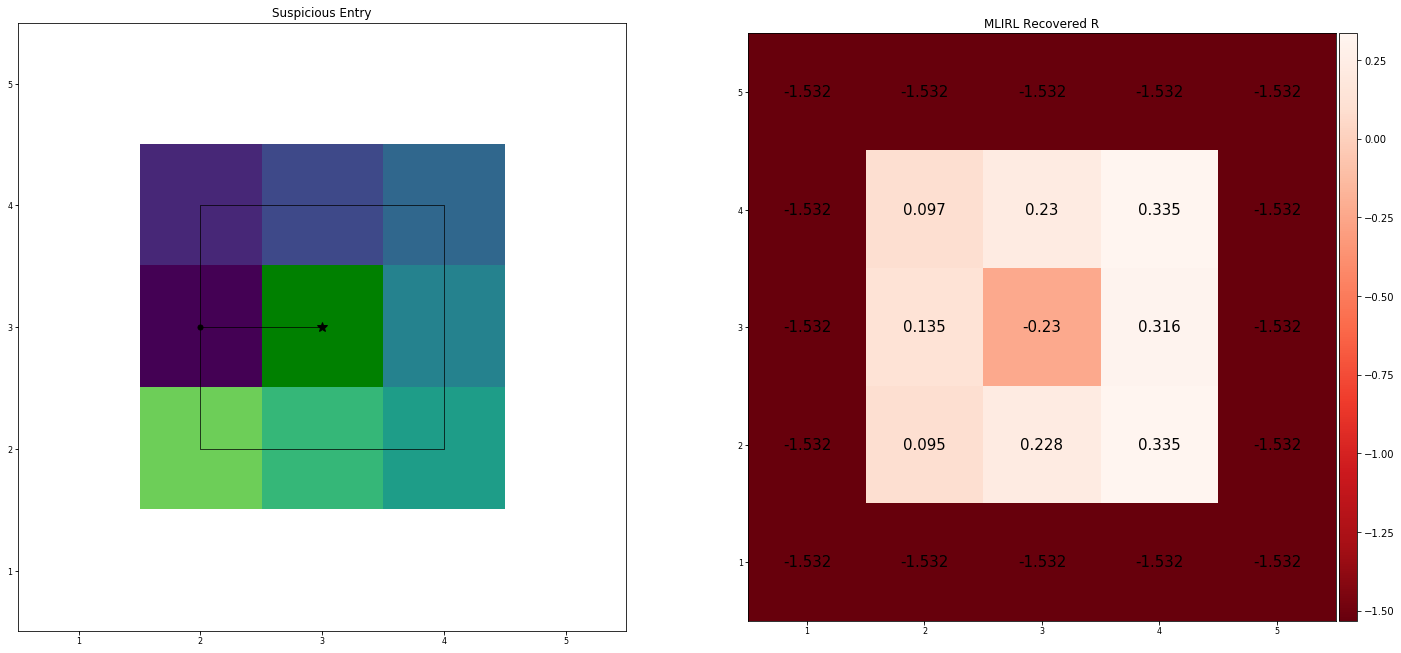

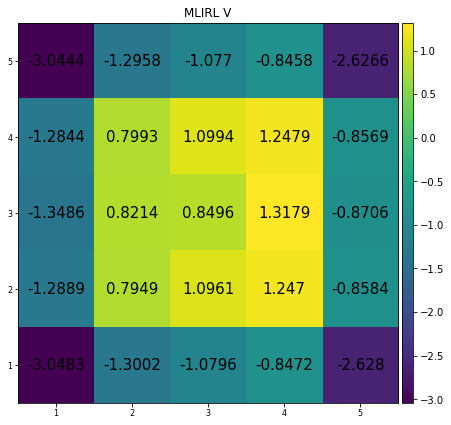

In [17]:
mlirl_params = dict(
    n_iter = 20,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.95,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 5,
    height = 5,
    cell_types = ['white', "green"] + list(range(8)),
    cell_locs = [np.inf, [(3,3)], [(2,3)], [(2,4)], [(3,4)], [(4,4)], [(4,3)], [(4,2)], [(3,2)], [(2,2)]],
    tau_s = [[(2,3),(2,4),(3,4),(4,4),(4,3),(4,2),(3,2),(2,2),(2,3),(3,3)]]
)
irl_problem = dict(
    mdp_params, 
    title="Suspicious Entry",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)

results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), results["V_grid"].round(4), irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

### Walk

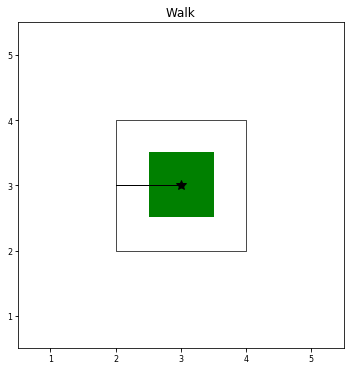

Training...
 				 	 white       green        	 white       green       
Iter: 0000, loss: 00013.862745, w: [-0.00700796 -0.00481599], dw: [-0.364527285 +0.489439487]
Iter: 0001, loss: 00013.859015, w: [-0.01058315 +0.00012656], dw: [-0.365977108 +0.491123497]
Iter: 0002, loss: 00013.851917, w: [-0.01735476 +0.00948483], dw: [-0.368790150 +0.494370043]
Iter: 0003, loss: 00013.841761, w: [-0.02696357 +0.02275612], dw: [-0.372897327 +0.499092668]
Iter: 0004, loss: 00013.828824, w: [-0.03907083 +0.03946365], dw: [-0.378288567 +0.505201101]
Iter: 0005, loss: 00013.813351, w: [-0.05335954 +0.05915780], dw: [-0.384841859 +0.512561321]
Iter: 0006, loss: 00013.795564, w: [-0.06953420 +0.08141658], dw: [-0.392410159 +0.520940959]
Iter: 0007, loss: 00013.775673, w: [-0.08732016 +0.10584471], dw: [-0.400632501 +0.529954314]
Iter: 0008, loss: 00013.753905, w: [-0.10646065 +0.13207114], dw: [-0.408962637 +0.538988948]
Iter: 0009, loss: 00013.730511, w: [-0.12671210 +0.15974408], dw: [-0.416590124 +0

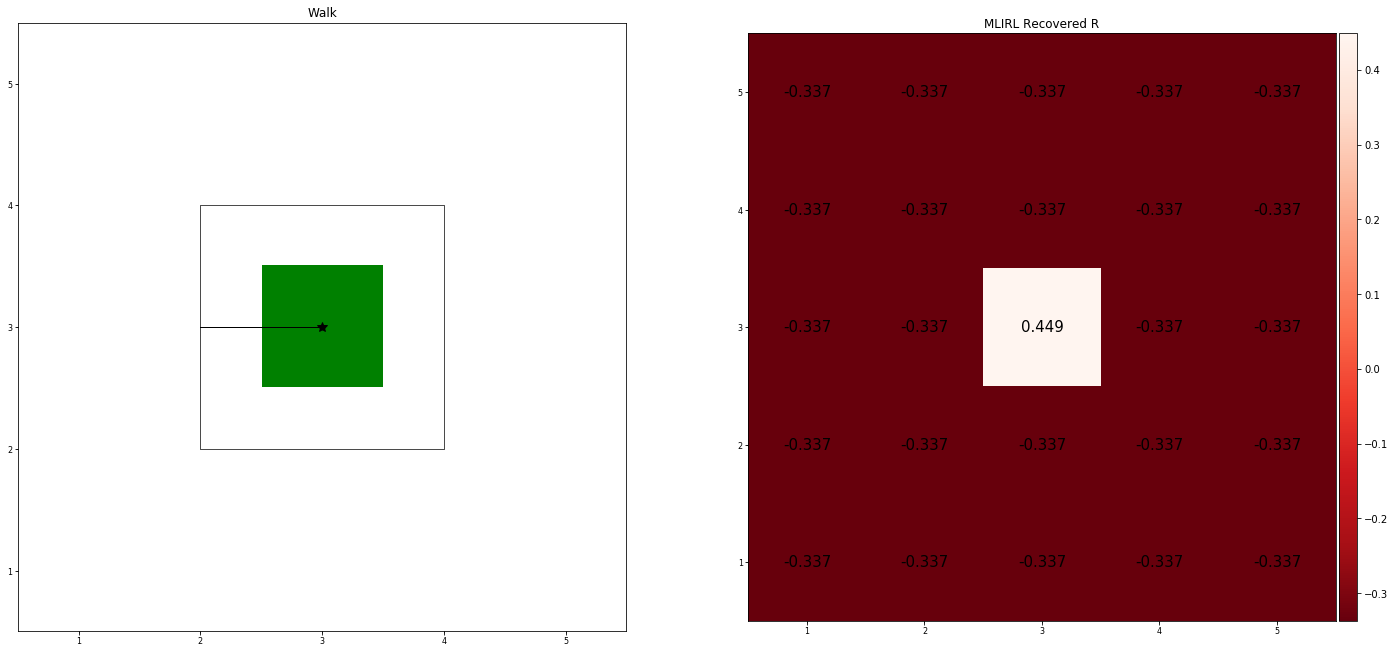

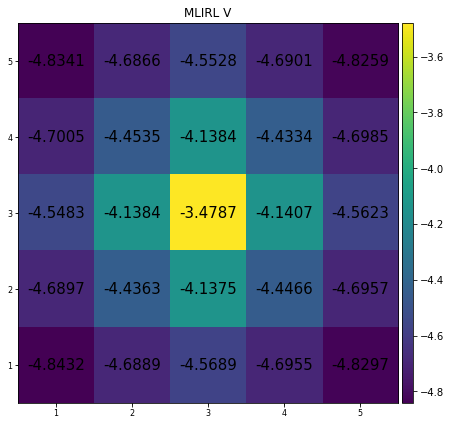

In [18]:
mlirl_params = dict(
    n_iter = 20,
    n_vi_iter = 30,
    dtype = torch.float,
    gamma = 0.95,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 5,
    height = 5,
    cell_types = ['white', "green"],
    cell_locs = [np.inf, [(3,3)]],
    tau_s = [[(3,3),(2,3),(2,4),(3,4),(4,4),(4,3),(4,2),(3,2),(2,2),(2,3),(3,3)]]
)
irl_problem = dict(
    mdp_params, 
    title="Walk",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)

results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), results["V_grid"].round(4), irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

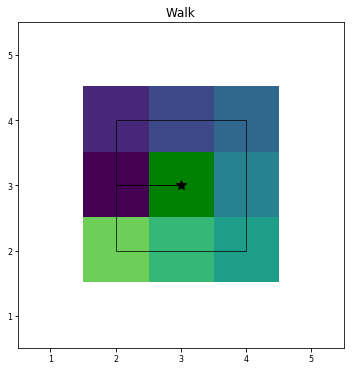

Training...
 				 	 white       green                 0           1           2           3           4           5           6           7  	 white       green                 0           1           2           3           4           5           6           7 
Iter: 0000, loss: 00013.841687, w: [-0.00422291 +0.00910461 -0.00723788 -0.01385374 -0.01349603 +0.00837604 +0.00957978 +0.00732897 +0.00409424 +0.00396980], dw: [-5.601580143 +0.491870582 +1.462819457 +0.533888459 +0.526591241 +0.558690071 +0.533007741 +0.558869481 +0.526092649 +0.536077023]
Iter: 0001, loss: 00013.495128, w: [-0.06019648 +0.01393227 +0.00746269 -0.00837632 -0.00809515 +0.01387918 +0.01481406 +0.01284438 +0.00931423 +0.00929087], dw: [-5.228564739 +0.460473299 +1.407537222 +0.490514934 +0.485629737 +0.521130383 +0.493116468 +0.520131946 +0.482801765 +0.489242047]
Iter: 0002, loss: 00012.933611, w: [-0.16225637 +0.02274258 +0.03469395 +0.00154227 +0.00170288 +0.02390451 +0.02430794 +0.02288112 +0.01874709 +0.0

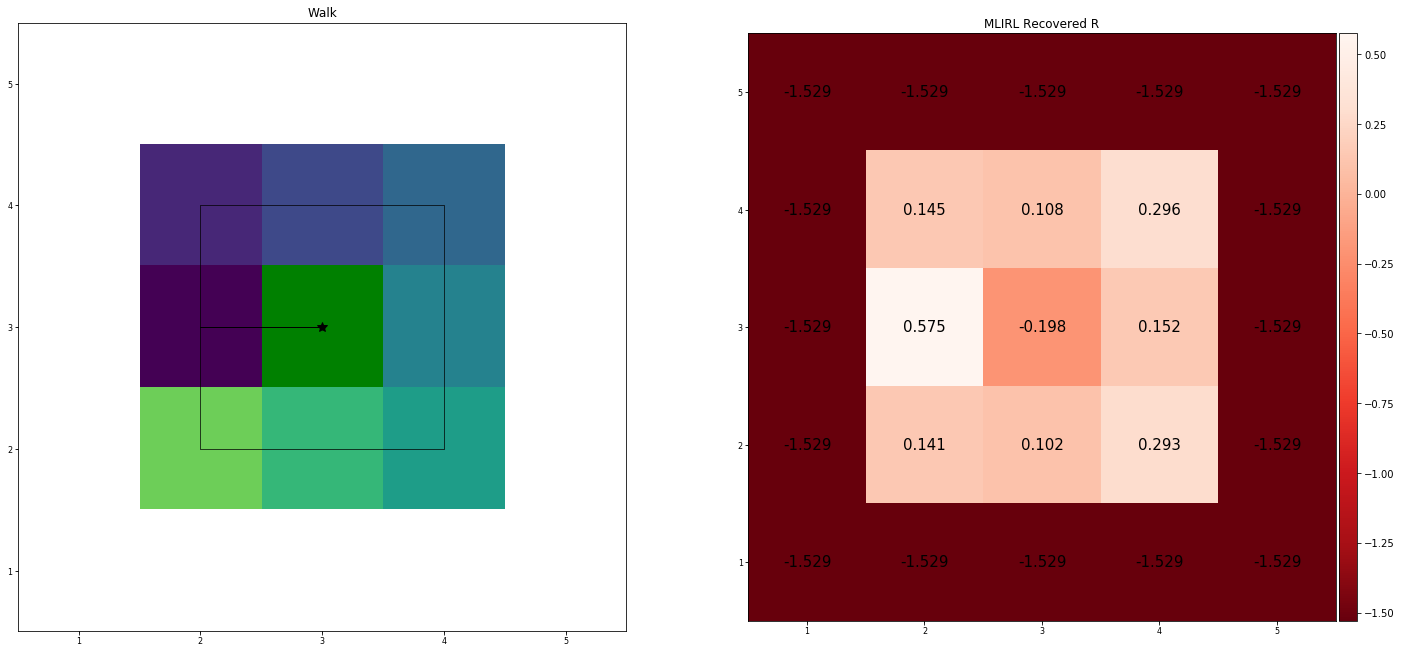

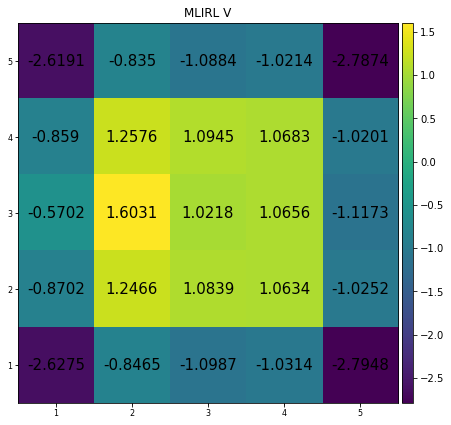

In [19]:
mlirl_params = dict(
    n_iter = 20,
    n_vi_iter = 30,
    dtype = torch.float,
    gamma = 0.95,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 5,
    height = 5,
    cell_types = ['white', "green"] + list(range(8)),
    cell_locs = [np.inf, [(3,3)], [(2,3)], [(2,4)], [(3,4)], [(4,4)], [(4,3)], [(4,2)], [(3,2)], [(2,2)]],
    tau_s = [[(3,3),(2,3),(2,4),(3,4),(4,4),(4,3),(4,2),(3,2),(2,2),(2,3),(3,3)]]
)
irl_problem = dict(
    mdp_params, 
    title="Walk",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)

results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), results["V_grid"].round(4), irl_problem["title"], rewards_cmap=plt.cm.Reds_r)